# PREDICT LOAN DEFAULT

> The objective is to write an algorithm so that given a new loan, we can predict whether it will default or not. The metric that we will use to evaluate the quality of our algorithm is the AUC. 

> Data using mock data, taken from [Here](https://www.dropbox.com/s/oj8ngm5g2ytqt42/sample_200_0k_20170120.rar?dl=0)

> Each row corresponds to a loan. It includes the borrower's demographics, income, education, etc. It also includes how many days the loan is overdue: ie, the maxoverduedays column. If maxoverduedays>90, we say that theborrower has defaulted on the loan.

> Data Dictionary : 
> - jobpos: job position
> - xxx_lat: xxx latitude
> - xxx_long: xxx longitude
> - legal_xxx: legal address xxx
> - avg: average
> - std: standard deviation
> - cnt: count
> - xxx_nation: attribute for the nation where the borrower belongs
> - xxx_area: attribute for the area where the borrower belongs

# IMPORT LIBRARIES

In [1]:
# data wrangling

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# data visualization

import matplotlib.pyplot as plt
import seaborn as sns

# feature engineering

from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from time import time

# modelling

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# filter warning

import warnings
warnings.filterwarnings('ignore')

# OVERVIEW

> To start with, I'll load the data and see the overall summary of this data.

In [2]:
# load data

df = pd.read_csv('sample_200_0k_20170120.csv')

In [3]:
# show top 10

df.head(10)

,gender,birthdate,maritalstatus,numofdependence,education,professionid,homestatus,staysinceyear,EmploymentSinceYear,MainBusinessSinceYear,jobtypeid,jobpos,monthlyfixedincome,monthlyvariableincome,spouseincome,newapplicationdate,MaxOverDueDays,residencezipcode,companyzipcode,legalzipcode,residence_lat,residence_long,company_lat,company_long,legal_lat,legal_long,birthplace,avg_income,std_income,avg_income_cnt,avg_income_nation,std_income_nation,avg_income_nation_cnt,avg_income_area,std_icnome_area,avg_income_area_cnt,avg_sale_house_price_5000,std_sale_house_price_5000,sale_house_cnt_5000,avg_sale_apartment_price_5000,std_sale_apartment_price_5000,sale_apartment_cnt_5000,avg_rent_house_price_5000,std_rent_house_price_5000,rent_house_cnt_5000,avg_rent_apartment_price_5000,std_rent_apartment_price_5000,rent_apartment_cnt_5000,avg_sale_house_price_10000,std_sale_house_price_10000,sale_house_cnt_10000,avg_sale_apartment_price_10000,std_sale_apartment_price_10000,sale_apartment_cnt_10000,avg_rent_house_price_10000,std_rent_house_price_10000,rent_house_cnt_10000,avg_rent_apartment_price_10000,std_rent_apartment_price_10000,rent_apartment_cnt_10000,previous,distance_residence_company
0,Male,1985-12-15T17:00:00.000+00:00,SINGLE,0,BACHELOR_DEGREE,Government employees,4,2010.0,2006.0,NaN,Others,Staff,4000000.0,0.0,0.0,2012-09-05T04:49:50.000+00:00,0.0,33117.0,33117.0,40256.0,-2.188377,106.116930,-2.188377,106.116930,-6.965395,107.614134,BANDUNG,3.905436e+06,2.336988e+06,1775.0,9.336151e+08,9.643547e+11,1075437.0,4.391341e+06,2.876481e+06,3939.0,6.484425e+08,5.508472e+08,19.0,5.721607e+08,2.568821e+08,21.0,3.547664e+07,5.030641e+07,179.0,3.619348e+07,7.643707e+07,23.0,8.017849e+08,7.165296e+08,180.0,5.367837e+08,2.199754e+08,26.0,7.216985e+07,3.546624e+08,406.0,5.366614e+06,2.020980e+07,121.0,NaN,0.00000
1,Male,1969-12-20T17:00:00.000+00:00,MARRIED,2,ELEMENTARY_SCHOOL,Entrepreneur,1,1992.0,NaN,2005.0,Entrepreneur,NaN,3000000.0,0.0,0.0,2012-09-11T03:46:42.000+00:00,7.0,33681.0,33681.0,33681.0,-2.624456,106.581979,-2.624456,106.581979,-2.624456,106.581979,JAWA TENGAH,3.308757e+06,9.339743e+05,2139.0,4.792272e+06,3.890322e+08,1418874.0,3.343014e+06,1.064039e+06,2442.0,1.663636e+09,1.567656e+09,11.0,3.316614e+08,1.278616e+08,20.0,3.547664e+07,5.030641e+07,179.0,3.619348e+07,7.643707e+07,23.0,1.501077e+09,1.652409e+09,13.0,5.573542e+08,2.387715e+08,18.0,7.216985e+07,3.546624e+08,406.0,5.366614e+06,2.020980e+07,121.0,"2012-09-11 03:40:58,2850000.00,7,0.00",0.00000
2,Female,1976-08-17T17:00:00.000+00:00,MARRIED,2,SENIOR_HIGH_SCHOOL,Entrepreneur,1,2008.0,NaN,2010.0,Entrepreneur,NaN,3000000.0,0.0,0.0,2012-09-17T02:19:57.000+00:00,17.0,33674.0,33674.0,33674.0,-2.346277,105.993491,-2.346277,105.993491,-2.346277,105.993491,PANGKALPINANG,4.109646e+06,3.383104e+06,311.0,4.792272e+06,3.890322e+08,1418874.0,4.074921e+06,3.171127e+06,381.0,1.663636e+09,1.567656e+09,11.0,3.316614e+08,1.278616e+08,20.0,3.547664e+07,5.030641e+07,179.0,3.619348e+07,7.643707e+07,23.0,1.501077e+09,1.652409e+09,13.0,5.573542e+08,2.387715e+08,18.0,7.216985e+07,3.546624e+08,406.0,5.366614e+06,2.020980e+07,121.0,NaN,0.00000
3,Male,1985-01-09T17:00:00.000+00:00,MARRIED,1,ELEMENTARY_SCHOOL,Entrepreneur,1,2002.0,NaN,2005.0,Entrepreneur,NaN,5000000.0,0.0,0.0,2012-09-21T01:28:04.000+00:00,10.0,33782.0,33782.0,33782.0,-2.703447,106.393478,-2.703447,106.393478,-2.703447,106.393478,JAMBI,3.489542e+06,5.893143e+06,459.0,4.792272e+06,3.890322e+08,1418874.0,3.537224e+06,5.802110e+06,479.0,6.318182e+08,5.085613e+08,11.0,3.316614e+08,1.278616e+08,20.0,3.547664e+07,5.030641e+07,179.0,3.619348e+07,7.643707e+07,23.0,1.501077e+09,1.652409e+09,13.0,5.573542e+08,2.387715e+08,18.0,7.216985e+07,3.546624e+08,406.0,5.366614e+06,2.020980e+07,121.0,NaN,0.00000
4,Female,1979-08-16T17:00:00.000+00:00,MARRIED,1,ELEMENTARY_SCHOOL,Entrepreneur,1,2007.0,NaN,2007.0,Entrepreneur,NaN,3800000.0,0.0,0.0,2012-09-26T03:16:50.000+00:00,10.0,33172.0,33172.0,33172.0,-2.042226,106.087533,-2.042226,106.087533,-2.042226,106.08

In [4]:
# check info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 62 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   gender                          200000 non-null  object 
 1   birthdate                       200000 non-null  object 
 2   maritalstatus                   199992 non-null  object 
 3   numofdependence                 200000 non-null  int64  
 4   education                       200000 non-null  object 
 5   professionid                    200000 non-null  object 
 6   homestatus                      200000 non-null  int64  
 7   staysinceyear                   200000 non-null  float64
 8   EmploymentSinceYear             108860 non-null  float64
 9   MainBusinessSinceYear           94683 non-null   float64
 10  jobtypeid                       199863 non-null  object 
 11  jobpos                          114845 non-null  object 
 12  monthlyfixedinco

> We can see that there are many Null values on these features, I'll try to see more of this below.

In [5]:
# function to check data summary

def summary(df):
    
    columns = df.columns.to_list()
    
    dtypes = []
    unique_counts = []
    missing_counts = []
    missing_percentages = []
    total_counts = [df.shape[0]] * len(columns)

    for col in columns:
        dtype = str(df[col].dtype)
        dtypes.append(dtype)
        unique_count = df[col].nunique()
        unique_counts.append(unique_count)
        missing_count = df[col].isnull().sum()
        missing_counts.append(missing_count)
        missing_percentage = round((missing_count/df.shape[0]) * 100, 2)
        missing_percentages.append(missing_percentage)

    df_summary = pd.DataFrame({
        "column": columns,
        "dtypes": dtypes,
        "unique_count": unique_counts,
        "missing_values": missing_counts,
        "missing_percentage": missing_percentages,
        "total_count": total_counts,
    })

    return df_summary.sort_values(by="missing_percentage", ascending=False).reset_index(drop=True)

In [6]:
# check summary

summary(df).head(20)

,column,dtypes,unique_count,missing_values,missing_percentage,total_count
0,previous,object,78978,121022,60.51,200000
1,MainBusinessSinceYear,float64,60,105317,52.66,200000
2,EmploymentSinceYear,float64,59,91140,45.57,200000
3,jobpos,object,5,85155,42.58,200000
4,avg_income,float64,14671,4300,2.15,200000
5,std_income,float64,14801,4300,2.15,200000
6,avg_income_cnt,float64,4178,4300,2.15,200000
7,company_long,float64,4014,4181,2.09,200000
8,distance_residence_company,float64,33205,4181,2.09,200000
9,companyzipcode,float64,5938,4181,2.09,200000


> There are several features that have more than 40% missing values, the rest is still below 3%. This number might not be a correct number, because it only comes from the given raw data with no preprocessing steps done yet. I'll fix it below.

> **If maxoverduedays>90, we say that the borrower has defaulted on the loan.**

In [7]:
# create target feature based of condition

df['flag_default'] = df['MaxOverDueDays'].apply(lambda x: 1 if x>90 else 0)

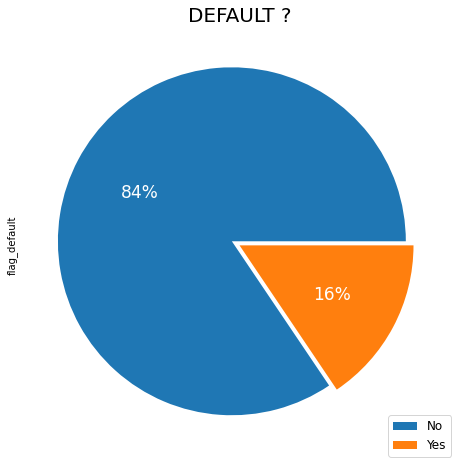

In [8]:
# show visualization on target feature

plt.figure(figsize=(8,8))
plt.title('DEFAULT ?', fontsize=20)
labels = 'No', 'Yes'
df['flag_default'].value_counts().plot(kind='pie', autopct='%0.0f%%', textprops={'fontsize':17, 'color':'white'}, explode = (0.05,0))
plt.legend(labels, loc='lower right', fontsize=12)
plt.show()

> We can see that the distribution of the **flag_default** is rather imbalanced, far more clients have <=90 days overdue. And this is normal in any of these cases.

In [9]:
# descriptive of numerical

df.describe().T

,count,mean,std,min,25%,50%,75%,max
numofdependence,200000.0,1.574785e+00,1.272720e+00,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,5.100000e+01
homestatus,200000.0,1.435765e+00,7.193236e-01,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,6.000000e+00
staysinceyear,200000.0,1.998311e+03,1.314722e+01,1.190000e+03,1.990000e+03,2.001000e+03,2.009000e+03,2.016000e+03
EmploymentSinceYear,108860.0,1.999425e+03,1.136454e+02,0.000000e+00,2.003000e+03,2.009000e+03,2.011000e+03,2.091000e+03
MainBusinessSinceYear,94683.0,2.005519e+03,7.205145e+00,1.012000e+03,2.003000e+03,2.007000e+03,2.010000e+03,2.016000e+03
monthlyfixedincome,200000.0,3.459823e+06,3.542789e+06,0.000000e+00,2.000000e+06,3.000000e+06,4.000000e+06,5.424148e+08
monthlyvariableincome,200000.0,1.646283e+05,1.227287e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+08
spouseincome,199992.0,3.715141e+04,4.585455e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.050000e+07
MaxOverDueDays,200000.0,5.570285e+01,1.256793e+02,0.000000e+00,1.000000e+00,7.000000e+00,3.600000e+01,1.601000e+03
residencezipcode,200000.0,6.278315e+04,2.646684e+04,0.000000e+00,4.022300e+04,6.617400e+04,9.023100e+04,9.800000e+04


In [10]:
# descriptive of numerical

df.describe(include=np.object).T

,count,unique,top,freq
gender,200000,3,Male,109850
birthdate,200000,15204,1965-12-30T17:00:00.000+00:00,222
maritalstatus,199992,4,MARRIED,166765
education,200000,9,SENIOR_HIGH_SCHOOL,114969
professionid,200000,5,Entrepreneur,95139
jobtypeid,199863,27,Entrepreneur,95025
jobpos,114845,5,Staff,93387
newapplicationdate,200000,199473,2015-05-04T07:43:23.000+00:00,3
birthplace,200000,17216,JAKARTA,6070
previous,78978,78978,"2013-09-25 23:57:12,3150000.00,20,356000.00;20...",1


> Seeing above data, it seems that there are some categorical features that interpreted as numerical (as they have number representation for the categories) and viceversa. For example on **numofdependece** and **homestatus**. Therefore I'll short it out first, and to make the process a little bit faster, I'll resample the data to only 40k data.

In [11]:
# select the columns

columns = ['monthlyfixedincome', 'monthlyvariableincome', 'spouseincome', \
           'avg_income', 'std_income', 'avg_income_cnt', 'avg_income_nation_cnt', \
           'avg_income_area', 'std_icnome_area', 'avg_income_area_cnt', 'avg_sale_house_price_5000', \
           'std_sale_house_price_5000', 'sale_house_cnt_5000', 'avg_sale_apartment_price_5000', \
           'std_sale_apartment_price_5000', 'sale_apartment_cnt_5000', \
           'avg_rent_house_price_5000', 'std_rent_house_price_5000', 'rent_house_cnt_5000', \
           'avg_rent_apartment_price_5000', 'std_rent_apartment_price_5000', \
           'rent_apartment_cnt_5000', 'avg_sale_house_price_10000', 'std_sale_house_price_10000', \
           'sale_house_cnt_10000', 'avg_sale_apartment_price_10000', 'std_sale_apartment_price_10000', \
           'sale_apartment_cnt_10000', 'avg_rent_house_price_10000', 'std_rent_house_price_10000', \
           'rent_house_cnt_10000', 'avg_rent_apartment_price_10000', 'std_rent_apartment_price_10000', \
           'rent_apartment_cnt_10000', 'distance_residence_company']

In [12]:
# randomly choose 40k samples from the data

r = np.random.RandomState(42)
res = r.choice(df.shape[0], size=40000, replace=False)

In [13]:
# function to visualize scatter plot

def plot_feature_scatter(df1, df2, features, size=[4,4]):
    i = 0
    sns.set_style("whitegrid")
    plt.figure
    
    fig, ax = plt.subplots(size[0], size[1], figsize=(size[1]*5, size[0]*5))
    
    for feature in features:
        i += 1
        plt.subplot(size[0], size[1], i)
        plt.scatter(df1[feature], df2[feature], marker="*", color='#2B3A67', alpha=0.2)
        plt.xlabel(feature, fontsize=9)
    
    plt.show()

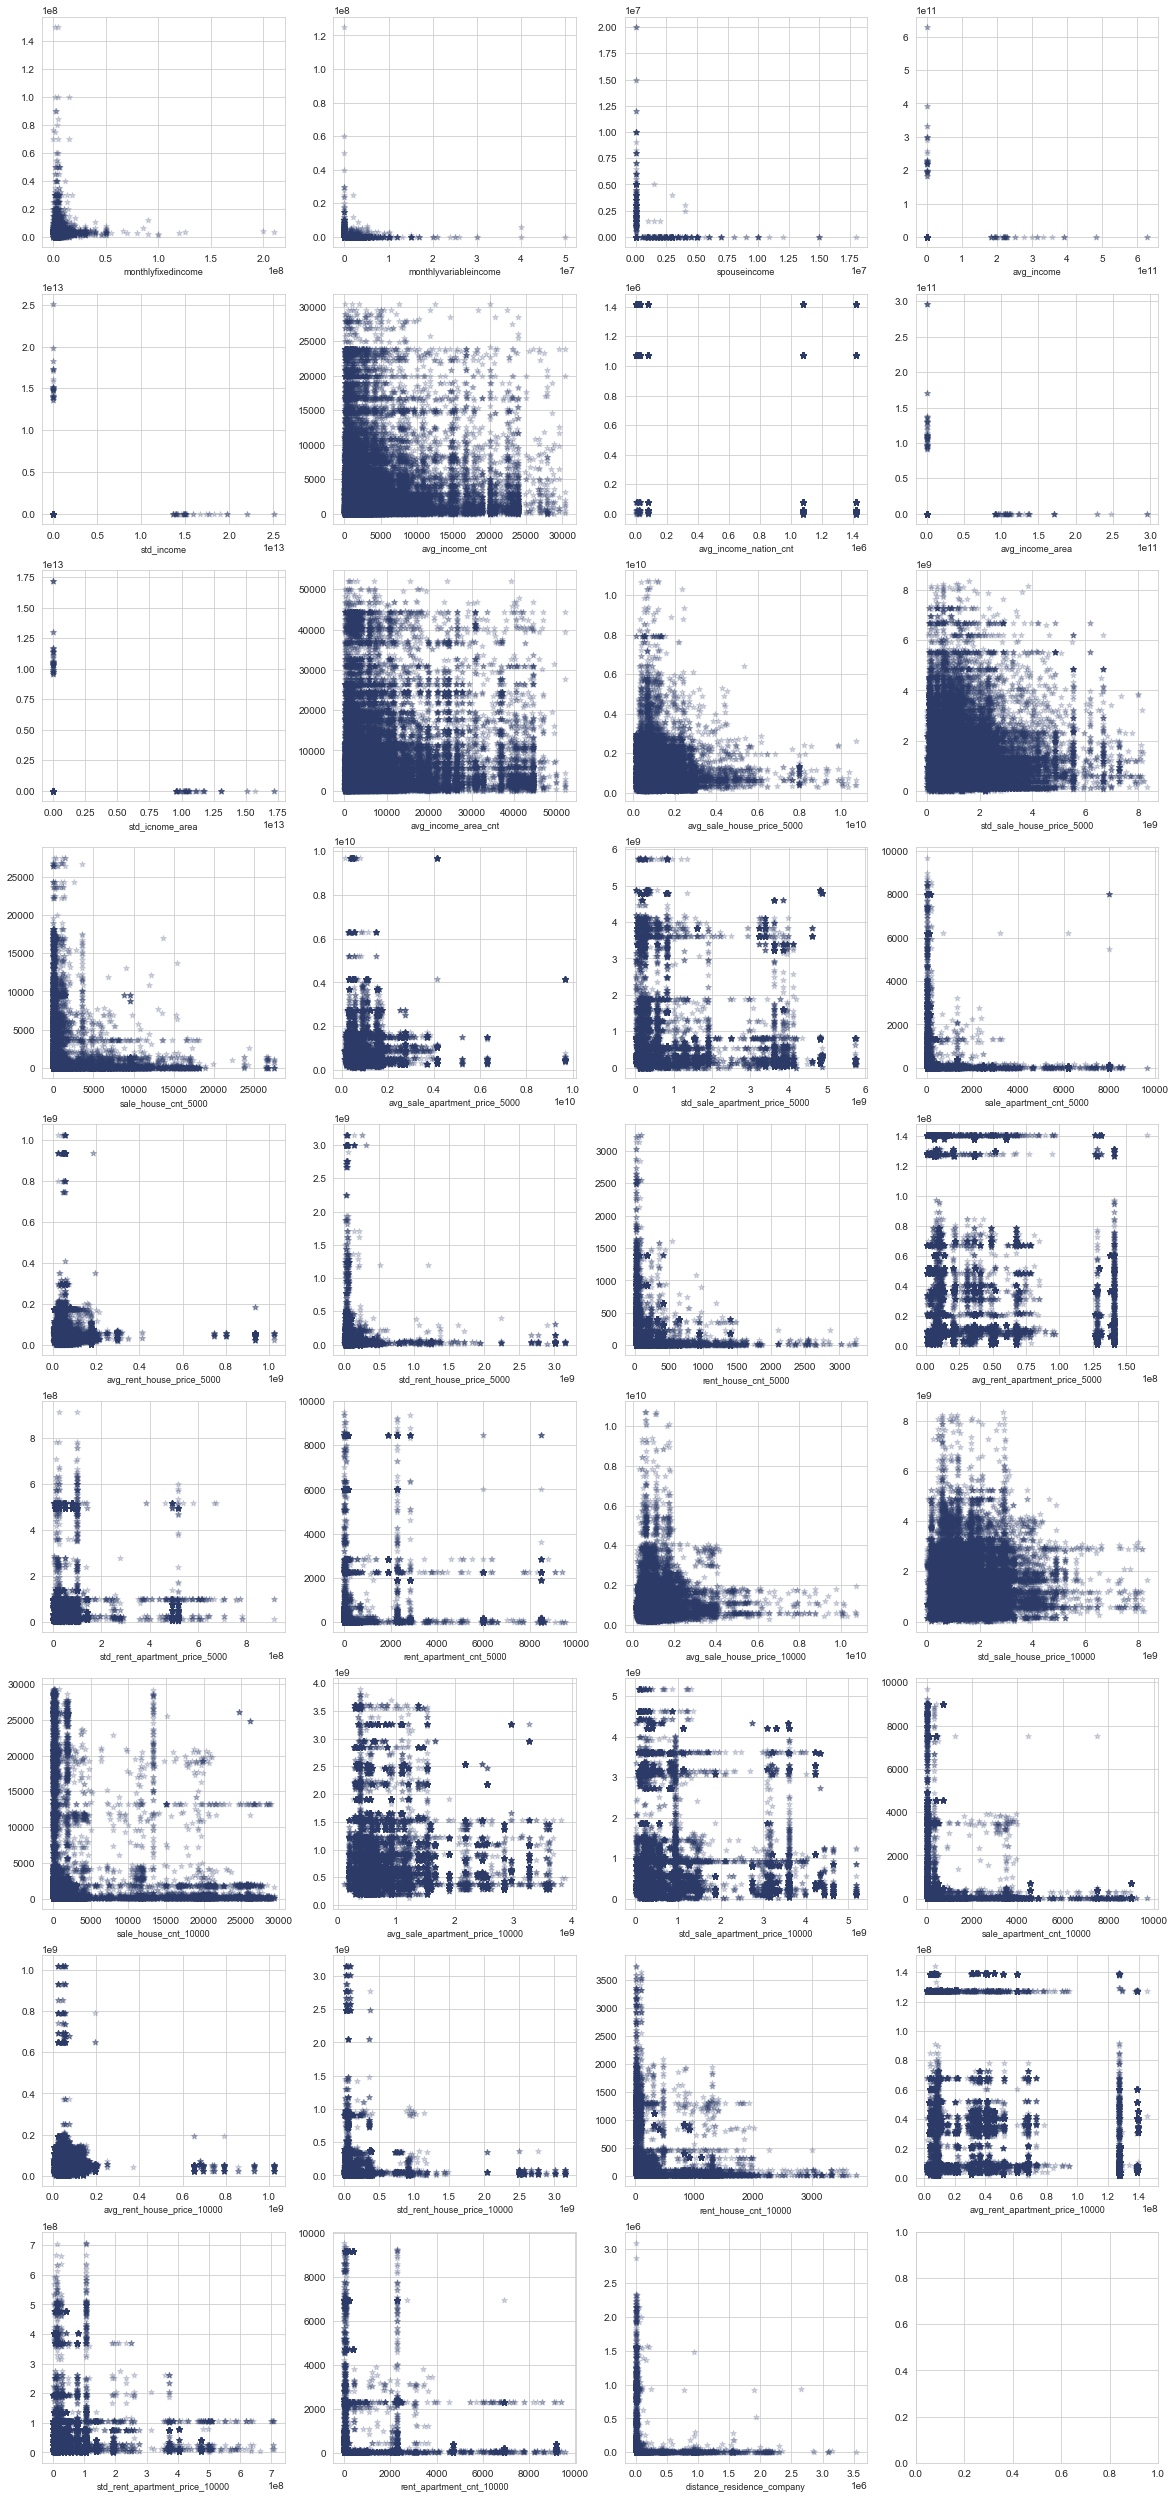

In [14]:
# visualize with scatter plot

plot_feature_scatter(df.iloc[res], df.iloc[~res], columns, size=[9,4])

> Fist of all, from this plot we can see the features distribution of the data. We can also see there are some strong outliers in several features. For example in the **income** and **rent_house_price**. The general pattern of the features are more dense to the smaller values and become more less dense as the values increased.

> Let's do another thing, for example we may want to see the kernel density estimation plot. This is useful to visualize the effect of a feature on our target.

In [15]:
# function to visualize kde plot

def plot_feature_kde(df1, df2, label1, label2, features, size=[4,4]):
  
    i = 0
    sns.set_style("whitegrid")

    plt.figure()
    fig, ax = plt.subplots(size[0], size[1], figsize=(size[1]*5, size[0]*5))

    for feature in features:
        i += 1
        plt.subplot(size[0], size[1], i)

        sns.kdeplot(df1[feature], label=label1, color="#5982C5")
        sns.kdeplot(df2[feature], label=label2, color="#FB3523")

        plt.xlabel(feature, fontsize=9)

        locs, labels = plt.xticks()
        plt.tick_params(axis="x", which="major", labelsize=6, pad=6)
        plt.tick_params(axis="y", which="major", labelsize=6)

    plt.show()

In [16]:
# split the default and not default

df_good = df.loc[df['flag_default'] == 0]
df_bad  = df.loc[df['flag_default'] == 1]

<Figure size 432x288 with 0 Axes>

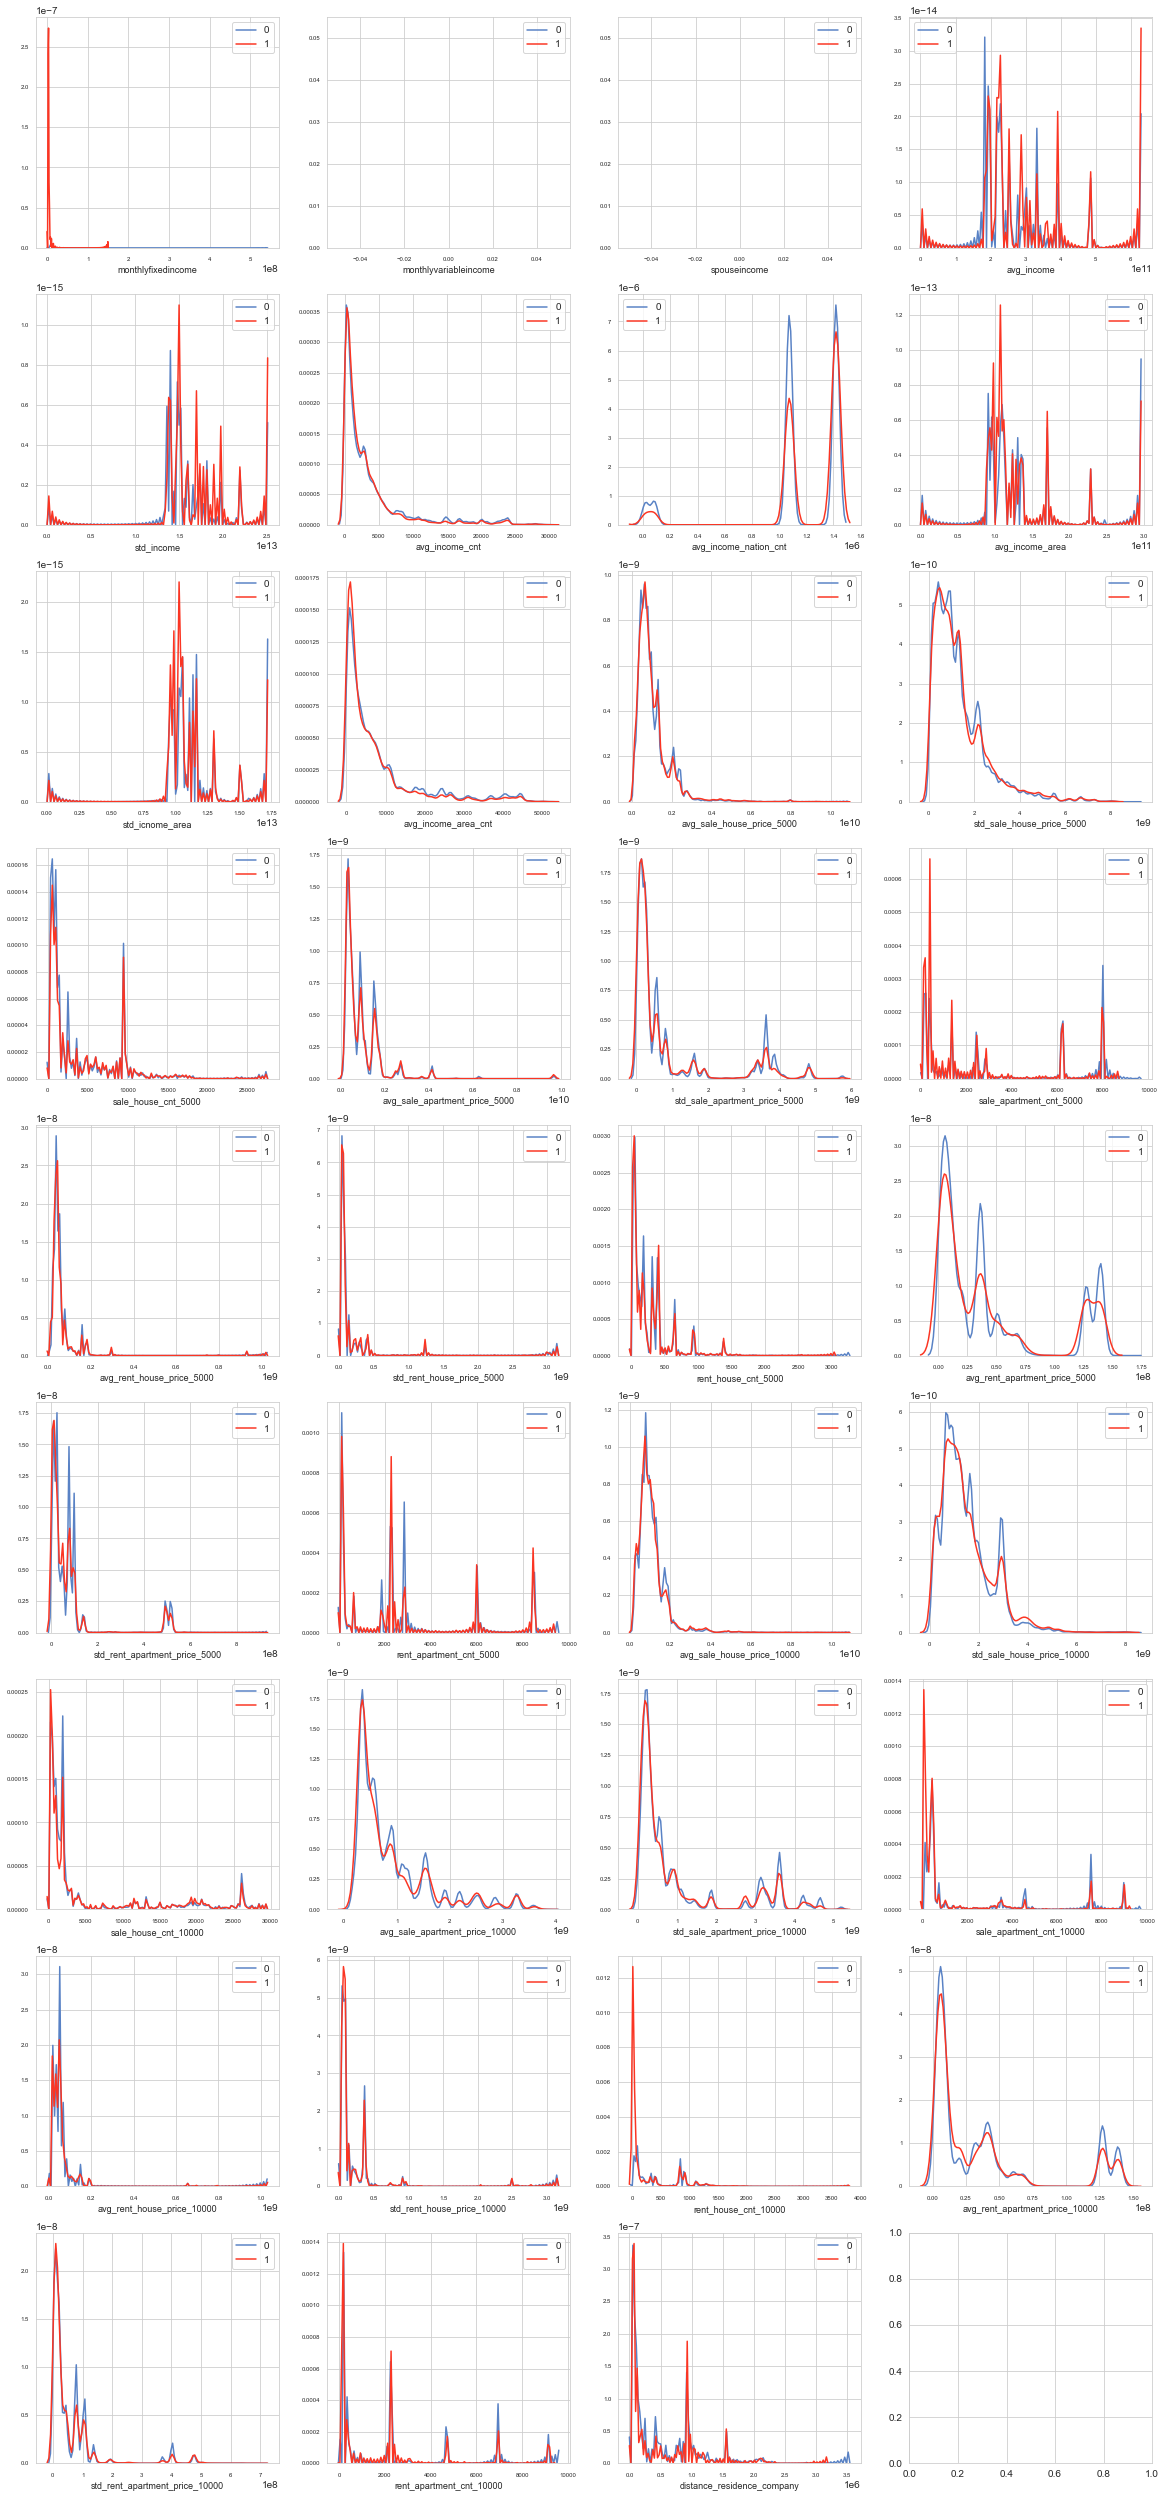

In [17]:
# visualize with kde plot

plot_feature_kde(df_good, df_bad, '0', '1', columns, size=[9, 4])

> Although it's rather hard, now we can see some promising features to include when building our predictive model, such features are the ones that can shows difference between the values of the target. To put it on certain terms, it is the one that able to distinguish between flag_default 0 or 1. For example the **apartment_price, house_price** and **income**

> To further proof this findings, let's visualize the correlation heatmap for the features.

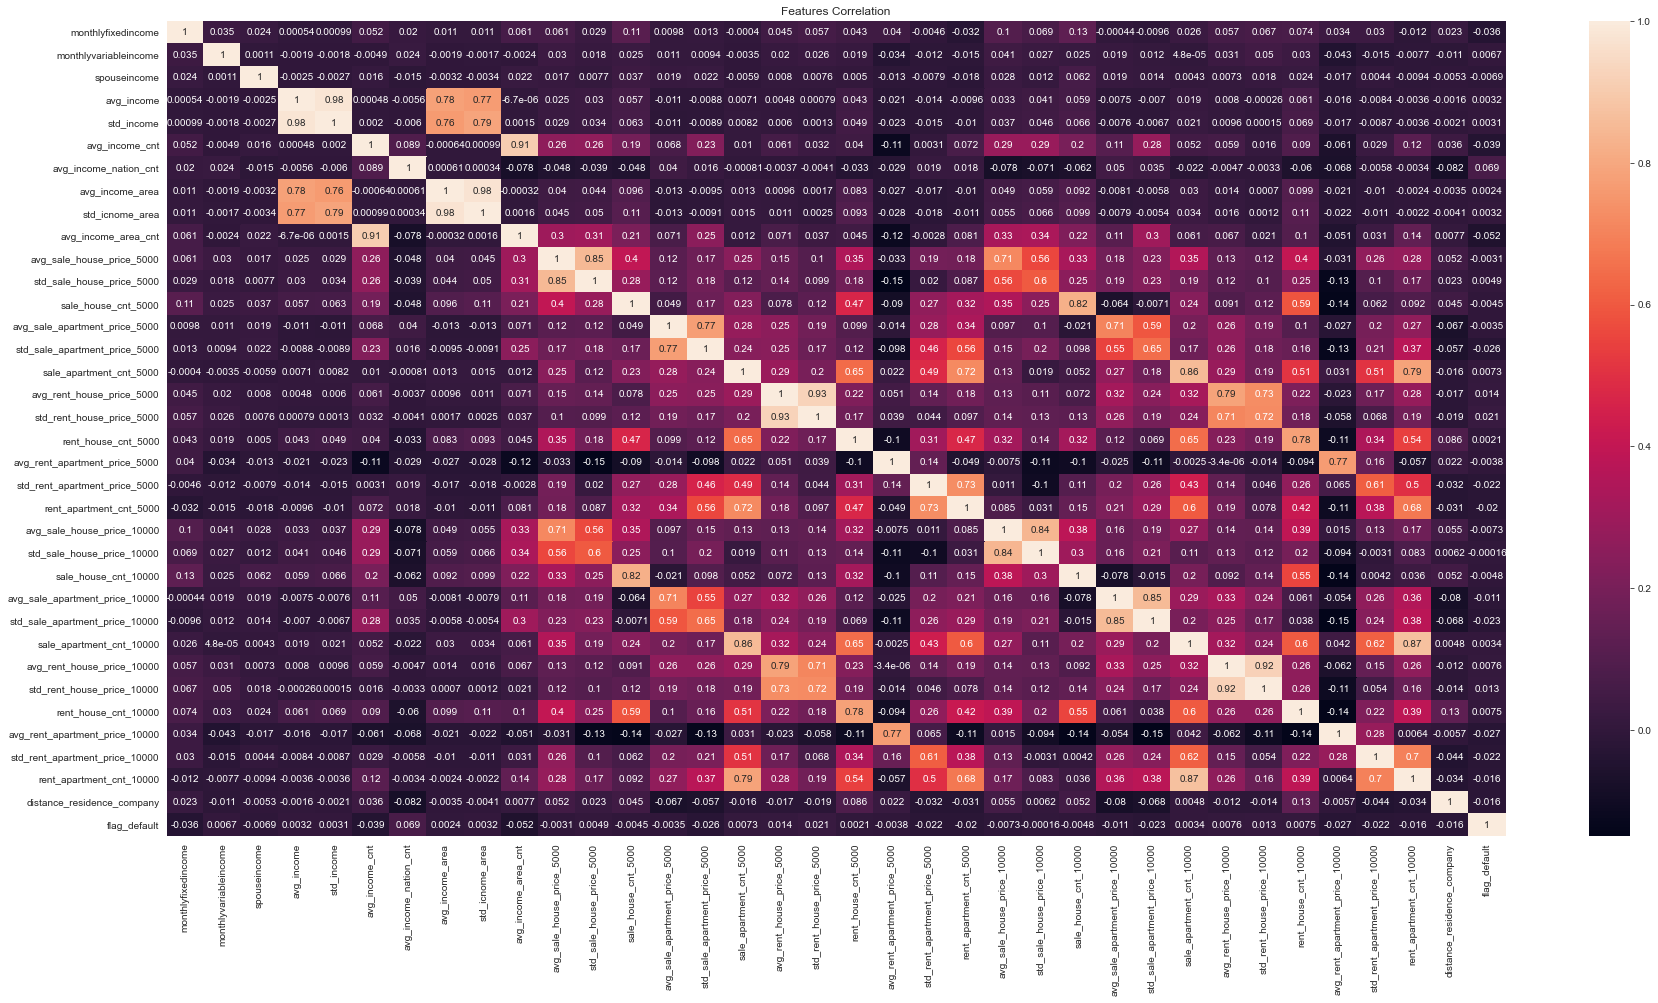

In [18]:
# visualize correlation using heatmap

plt.figure(figsize = (30,15))
sns.heatmap(df[columns+['flag_default']].corr(), annot=True)
plt.title('Features Correlation')
plt.show()

In [19]:
# see highest and lowest correlation

highest_corr = df[columns+['flag_default']].corr()['flag_default'].sort_values()

print(f'Most positive correlation: {highest_corr.head(5).index.to_list()}')
print(f'Most negative correlation: {highest_corr.tail(5).index.to_list()}')

Most positive correlation: ['avg_income_area_cnt', 'avg_income_cnt', 'monthlyfixedincome', 'avg_rent_apartment_price_10000', 'std_sale_apartment_price_5000']
Most negative correlation: ['std_rent_house_price_10000', 'avg_rent_house_price_5000', 'std_rent_house_price_5000', 'avg_income_nation_cnt', 'flag_default']


> Seems that it is true that some features indicated from the kdeplot are indeed the features that most correlated to the target (most positive or negative correlation).

> Now before moving to feature engineering, I'll label the categorical data using *label encoding technique* instead of *one hot encoding*, as some of the categorical columns have a big number of categories. So we used this to eliminate any problem that may arise.

# PREPROCESSING & FEATURE ENGINEERING

In [24]:
# function to automate preprocess & feature engineering

def loan_feat_engineering(df):
    
    #start time
    
    begin = time()
    print('Starting...')
    
    # label encode the categorical columns

    cat_cols = ['gender', 'maritalstatus', 'education', 'professionid', 'jobtypeid', 'jobpos', 'birthplace']

    le = LabelEncoder()

    for col in cat_cols:
        df.loc[pd.isnull(df[col]),[col]] = 'NaN'
        df[cat_cols] = df[cat_cols].astype('str')
        df[cat_cols] = df[cat_cols].apply(lambda x: le.fit_transform(x))
    
    # calculate the days different between application and birth
    
    df[['birthdate', 'newapplicationdate']] = df[['birthdate', 'newapplicationdate']].astype('datetime64[D]')
    df['days_to_birth'] = (df['birthdate'] - df['newapplicationdate']).astype('timedelta64[D]')
    
    # take the features from previous column (only the first previous)
    
    prev_split = df['previous'].apply(lambda x: str(x).split(','))
    prev_date = []
    prev_feat1 = []
    prev_feat2 = []
    prev_feat3 = []
    
    for v in prev_split.values:
        if v[0] == 'nan':
            prev_date.append(np.nan)
            prev_feat1.append(np.nan)
            prev_feat2.append(np.nan)
            prev_feat3.append(np.nan)
        else:
            prev_date.append(v[0])
            prev_feat1.append(float(v[1]))
            prev_feat2.append(int(v[2]))
            prev_feat3.append(float(v[3].split(';')[0]))
            
    df['prev_date'] = prev_date
    df['prev_feat1'] = prev_feat1
    df['prev_feat2'] = prev_feat2
    df['prev_feat3'] = prev_feat3

    # calculate the days different between prev and new application
    
    df['prev_date'] = df['prev_date'].astype('datetime64[D]')
    df['days_to_prev'] = (df['prev_date'] - df['newapplicationdate']).astype('timedelta64[D]')

    # calculate the years different between stay, employment, and main to new apps
    
    df['years_to_stay'] = df['staysinceyear'] - df['newapplicationdate'].apply(lambda x: x.year)
    df['years_to_employment'] = df['EmploymentSinceYear'] - df['newapplicationdate'].apply(lambda x: x.year)
    df['years_to_mainbusiness'] = df['MainBusinessSinceYear'] - df['newapplicationdate'].apply(lambda x: x.year)

    # calculate the years different between stay, employment, and main to birth
    
    df['years_to_stay_birth'] = df['staysinceyear'] - df['birthdate'].apply(lambda x: x.year)
    df['years_to_employment_birth'] = df['EmploymentSinceYear'] - df['birthdate'].apply(lambda x: x.year)
    df['years_to_mainbusiness_birth'] = df['MainBusinessSinceYear'] - df['birthdate'].apply(lambda x: x.year)

    # perc avg income by nation or area
    
    df['perc_avg_income_nation'] = df['avg_income'] / df['avg_income_nation']
    df['perc_std_income_nation'] = df['std_income'] / df['std_income_nation']
    df['perc_avg_income_cnt_nation'] = df['avg_income_cnt'] / df['avg_income_nation_cnt']

    df['perc_avg_income_area'] = df['avg_income'] / df['avg_income_area']
    df['perc_std_income_area'] = df['std_income'] / df['std_icnome_area']
    df['perc_avg_income_cnt_area'] = df['avg_income_cnt'] / df['avg_income_area_cnt']
    
    # create the target features
    
    df['flag_default'] = df['MaxOverDueDays'].apply(lambda x: 1 if x>90 else 0)
  
    print('End')
    print(f'Time Elapsed: {time()-begin}')
    return df

In [25]:
# start the feature engineering

df_loan = loan_feat_engineering(df)

Starting...
End
Time Elapsed: 21.798049688339233


In [23]:
# show top 5 data

df_loan.head()

,gender,birthdate,maritalstatus,numofdependence,education,professionid,homestatus,staysinceyear,EmploymentSinceYear,MainBusinessSinceYear,jobtypeid,jobpos,monthlyfixedincome,monthlyvariableincome,spouseincome,newapplicationdate,MaxOverDueDays,residencezipcode,companyzipcode,legalzipcode,residence_lat,residence_long,company_lat,company_long,legal_lat,legal_long,birthplace,avg_income,std_income,avg_income_cnt,avg_income_nation,std_income_nation,avg_income_nation_cnt,avg_income_area,std_icnome_area,avg_income_area_cnt,avg_sale_house_price_5000,std_sale_house_price_5000,sale_house_cnt_5000,avg_sale_apartment_price_5000,std_sale_apartment_price_5000,sale_apartment_cnt_5000,avg_rent_house_price_5000,std_rent_house_price_5000,rent_house_cnt_5000,avg_rent_apartment_price_5000,std_rent_apartment_price_5000,rent_apartment_cnt_5000,avg_sale_house_price_10000,std_sale_house_price_10000,sale_house_cnt_10000,avg_sale_apartment_price_10000,std_sale_apartment_price_10000,sale_apartment_cnt_10000,avg_rent_house_price_10000,std_rent_house_price_10000,rent_house_cnt_10000,avg_rent_apartment_price_10000,std_rent_apartment_price_10000,rent_apartment_cnt_10000,previous,distance_residence_company,flag_default,days_to_birth,prev_date,prev_feat1,prev_feat2,prev_feat3,days_to_prev,years_to_stay,years_to_employment,years_to_mainbusiness,years_to_stay_birth,years_to_employment_birth,years_to_mainbusiness_birth,perc_avg_income_nation,perc_std_income_nation,perc_avg_income_cnt_nation,perc_avg_income_area,perc_std_income_area,perc_avg_income_cnt_area
0,1,1985-12-15,2,0,0,2,4,2010.0,2006.0,NaN,2,3,4000000.0,0.0,0.0,2012-09-05,0.0,33117.0,33117.0,40256.0,-2.188377,106.116930,-2.188377,106.116930,-6.965395,107.614134,1907,3.905436e+06,2.336988e+06,1775.0,9.336151e+08,9.643547e+11,1075437.0,4.391341e+06,2.876481e+06,3939.0,6.484425e+08,5.508472e+08,19.0,5.721607e+08,2.568821e+08,21.0,3.547664e+07,5.030641e+07,179.0,3.619348e+07,7.643707e+07,23.0,8.017849e+08,7.165296e+08,180.0,5.367837e+08,2.199754e+08,26.0,7.216985e+07,3.546624e+08,406.0,5.366614e+06,2.020980e+07,121.0,NaN,0.0,0,-9761.0,NaT,NaN,NaN,NaN,NaN,-2.0,-6.0,NaN,25.0,21.0,NaN,0.004183,0.000002,0.001650,0.889349,0.812447,0.450622
1,1,1969-12-20,1,2,2,1,1,1992.0,NaN,2005.0,14,5,3000000.0,0.0,0.0,2012-09-11,7.0,33681.0,33681.0,33681.0,-2.624456,106.581979,-2.624456,106.581979,-2.624456,106.581979,2658,3.308757e+06,9.339743e+05,2139.0,4.792272e+06,3.890322e+08,1418874.0,3.343014e+06,1.064039e+06,2442.0,1.663636e+09,1.567656e+09,11.0,3.316614e+08,1.278616e+08,20.0,3.547664e+07,5.030641e+07,179.0,3.619348e+07,7.643707e+07,23.0,1.501077e+09,1.652409e+09,13.0,5.573542e+08,2.387715e+08,18.0,7.216985e+07,3.546624e+08,406.0,5.366614e+06,2.020980e+07,121.0,"2012-09-11 03:40:58,2850000.00,7,0.00",0.0,0,-15606.0,2012-09-11,2850000.0,7.0,0.0,0.0,-20.0,NaN,-7.0,23.0,NaN,36.0,0.690436,0.002401,0.001508,0.989753,0.877764,0.875921
2,0,1976-08-17,1,2,7,1,1,2008.0,NaN,2010.0,14,5,3000000.0,0.0,0.0,2012-09-17,17.0,33674.0,33674.0,33674.0,-2.346277,105.993491,-2.346277,105.993491,-2.346277,105.993491,12394,4.109646e+06,3.383104e+06,311.0,4.792272e+06,3.890322e+08,1418874.0,4.074921e+06,3.171127e+06,381.0,1.663636e+09,1.567656e+09,11.0,3.316614e+08,1.278616e+08,20.0,3.547664e+07,5.030641e+07,179.0,3.619348e+07,7.643707e+07,23.0,1.501077e+09,1.652409e+09,13.0,5.573542e+08,2.387715e+08,18.0,7.216985e+07,3.546624e+08,406.0,5.366614e+06,2.020980e+07,121.0,NaN,0.0,0,-13180.0,NaT,NaN,NaN,NaN,NaN,-4.0,NaN,-2.0,32.0,NaN,34.0,0.857557,0.008696,0.000219,1.008522,1.066846,0.816273
3,1,1985-01-09,1,1,2,1,1,2002.0,NaN,2005.0,14,5,5000000.0,0.0,0.0,2012-09-21,10.0,33782.0,33782.0,33782.0,-2.703447,106.393478,-2.703447,106.393478,-2.703447,106.393478,7930,3.489542e+06,5.893143e+06,459.0,4.792272e+06,3.890322e+08,1418874.0,3.537224e+06,5.802110e+06,479.0,6.318182e+08,5.085613e+08,11.0,3.316614e+08,1.278616e+08,20.0,3.547664e+07,5.030641e+07,179.0,3.619348e+07,7.643707e+07,23.0,1.501077e+09,1.652409e+09,13.0,5.573542e+08,2.387715e+08,18.0,7.2

# MODELLING

> Now I'll start the modelling part.

In [26]:
# split target features

X = df_loan[[col for col in df_loan.columns if col not in ['MaxOverDueDays', 'flag_default', 'birthdate', 'newapplicationdate', 'previous', 'prev_date']]]
y = df_loan['flag_default']

In [28]:
print(X, y)

        gender  maritalstatus  numofdependence  education  professionid  \
0            1              2                0          0             2   
1            1              1                2          2             1   
2            0              1                2          7             1   
3            1              1                1          2             1   
4            0              1                1          2             1   
...        ...            ...              ...        ...           ...   
199995       1              1                2          7             2   
199996       1              2                0          7             3   
199997       1              1                2          3             1   
199998       1              2                0          0             3   
199999       0              1                2          0             2   

        homestatus  staysinceyear  EmploymentSinceYear  MainBusinessSinceYear  \
0                4

> I'll split the data to train, test, and validation. And then continuing to model testing.

In [29]:
# train, test split 80 : 20 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [30]:
# train, valid split 80 : 25

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42, test_size=.25, stratify=y_train)

In [31]:
# check shape

X_train.shape, X_valid.shape, X_test.shape

((120000, 75), (40000, 75), (40000, 75))

In [33]:
# model training

clf = LGBMClassifier()

begin = time()
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], \
        eval_metric= 'auc', verbose= 10, early_stopping_rounds= 100)
print('Training Complete !')
print(f'Training Time: {time()-begin}')

Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.740655	training's binary_logloss: 0.389255	valid_1's auc: 0.73565	valid_1's binary_logloss: 0.390328
[20]	training's auc: 0.750542	training's binary_logloss: 0.37842	valid_1's auc: 0.740407	valid_1's binary_logloss: 0.381456
[30]	training's auc: 0.758948	training's binary_logloss: 0.372878	valid_1's auc: 0.744221	valid_1's binary_logloss: 0.378018
[40]	training's auc: 0.766059	training's binary_logloss: 0.368774	valid_1's auc: 0.746369	valid_1's binary_logloss: 0.376247
[50]	training's auc: 0.772558	training's binary_logloss: 0.365412	valid_1's auc: 0.747783	valid_1's binary_logloss: 0.375302
[60]	training's auc: 0.778253	training's binary_logloss: 0.362576	valid_1's auc: 0.748627	valid_1's binary_logloss: 0.37483
[70]	training's auc: 0.783696	training's binary_logloss: 0.359995	valid_1's auc: 0.74919	valid_1's binary_logloss: 0.374468
[80]	training's auc: 0.789067	training's binary_logloss: 0.357388	v

In [34]:
# feature importances

df_feat_importance = pd.DataFrame()
df_feat_importance['feature'] = X.columns.to_list()
df_feat_importance['scores'] = clf.feature_importances_

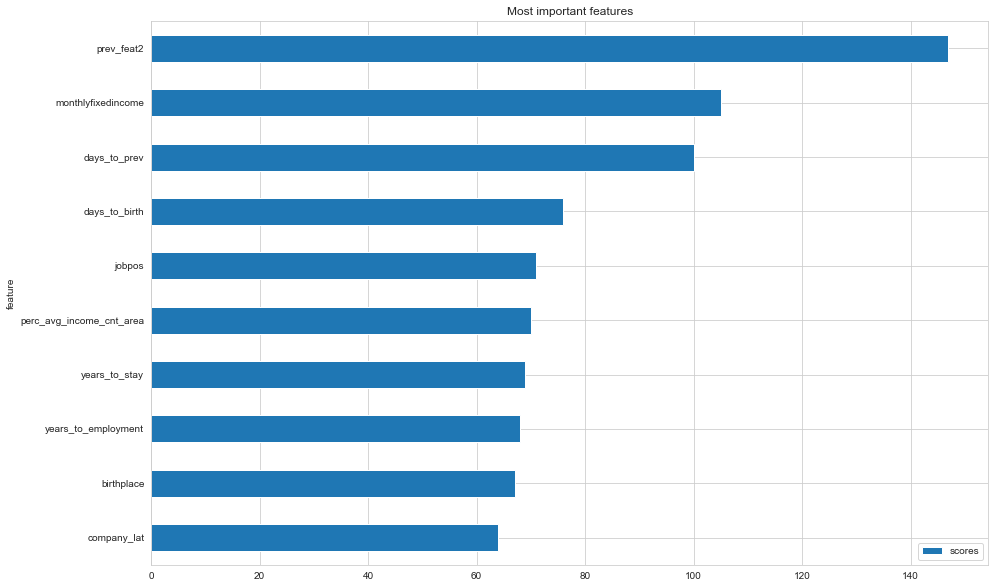

In [37]:
# visualize 10 top features

df_feat_importance.sort_values(by='scores', ascending=False).head(10).plot(x='feature', y='scores', kind='barh', figsize=(15,10))
plt.gca().invert_yaxis()
plt.title('Most important features')
plt.show()

> Now, what are some notable features of this data set ? 

> Here we can see the 10 most important features from our model, and most of our engineered features are make it to the list. For example the **prev_feat2**. Also **income** feature present on the list, this is one of the features that we predict will become important when we look at the kde and correlation plot.

In [40]:
# model evaluation using auc score

y_pred = clf.predict_proba(X_test)[:, 1]
print('AUC score: %.6f' % roc_auc_score(y_test, y_pred))

AUC score: 0.751749


# CONSLUSION

> **The model will be invalid if for example the are new category added to the categorical columns**, since this is a model based prediction it may be less accurate compared to professional human prediction. This model will valid only in a certain area presents in the data, so for example if you to use this model in another country it won't achieve the same result. 

> Also, **it seems the model are not overfit because if we see from the training and test results**. The difference in loss and auc of the model are in acceptable range. We can use crossvalidation, sure, but I think it was not necessary. Should our model proven to be overfit, then we can try to increase the training data, more selective with the features, and early stop the training part (already done).

> It only took a couple of seconds or one minute at most, and even less so if we only run the algorithm on small sample of the data. For example here we used 120k rows for training and 40k for both valid and test. The preprocessing and feature engineering part takes about 8 seconds, while the training part takes about 10 seconds.

> **Given more time to work on this problem for another week, we can :**
> 1. Try more features engineering.
> 2. Try with different classifier.
> 3. Try to oversample / undersample the data.
> 4. Try to impement another algorithms and might as well try more ensemble models.
> 5. Try to implement hyperparameter tuning, to find the best parameter for this model.